## План работы
Всего будет 5 шагов:
1. Откроем файл с данными и изучим общую информацию
2. Подготовка данных
3. Исследовательский анализ данных
4. Составление портрета пользователя каждого региона
5. Проверка гипотез

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
from scipy import stats as st
from matplotlib import pyplot as plt
from math import factorial
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
from scipy.stats import binom
pd.options.mode.chained_assignment = None

### Загрузка данных

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


### Изучение общей информации

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


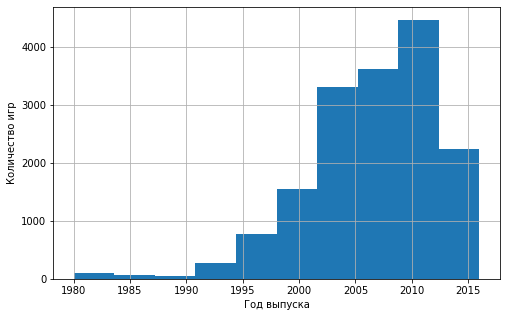

In [5]:
data['Year_of_Release'].hist(figsize=(8, 5))
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.show()

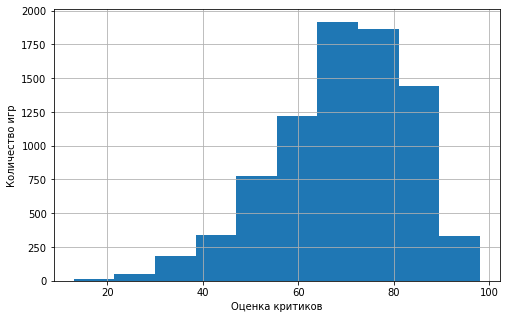

In [6]:
data['Critic_Score'].hist(figsize=(8, 5))
plt.xlabel('Оценка критиков')
plt.ylabel('Количество игр')
plt.show()

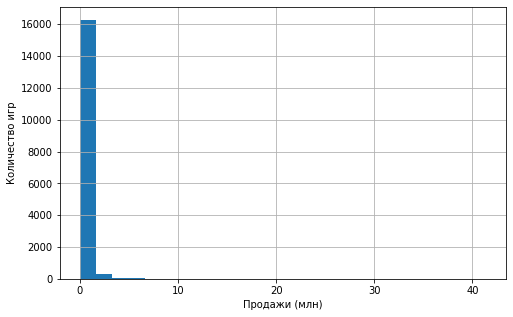

In [7]:
data['NA_sales'].hist(figsize=(8, 5), bins = 25 )
plt.xlabel('Продажи (млн)')
plt.ylabel('Количество игр')
plt.show()

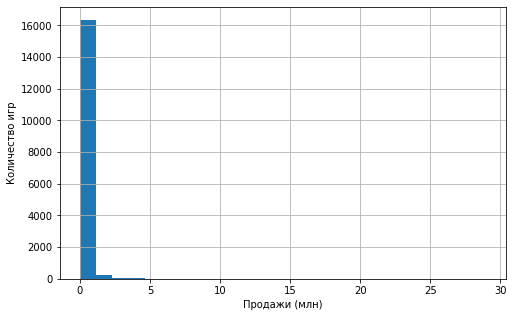

In [8]:
data['EU_sales'].hist(figsize=(8, 5), bins = 25 )
plt.xlabel('Продажи (млн)')
plt.ylabel('Количество игр')
plt.show()

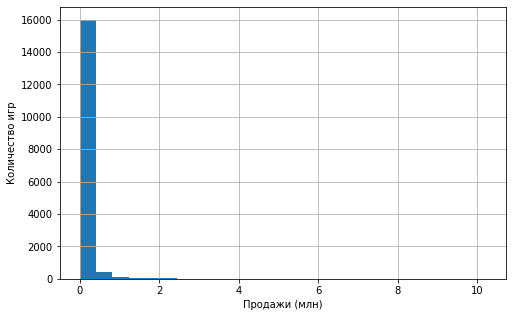

In [9]:
data['JP_sales'].hist(figsize=(8, 5), bins = 25 )
plt.xlabel('Продажи (млн)')
plt.ylabel('Количество игр')
plt.show()

**Вывод:** Загрузив и изучив информацию о данных, мы понимаем, что будем иметь дело с более чем 16000 наименований игр. В результате предобработки в следующем шаге, это число может измениться. Основная часть игр, с которыми нам предстоит работать выпускались с 2002 года. Оценки критиков по большей части варьируются в пределах 50-90 баллов. Очевидное замечание к данным - столбцы `Critic_Score`, `User_Score` и `Rating` имеют пропущенные значения. 

## Шаг 2. Подготовка данных

Для начала, приведем все названия столбцов к нижнему регистру.

In [10]:
data.columns = data.columns.str.lower()

### Предобработка данных

Для начала проверим какое количество пропусков в данных встречается и постараемся обработать данные случаи.

In [11]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

В столбце `name` встречаются 2 игры без названия. Их можно сразу удалить, ибо мы не сможем понять с чем имеем дело, а может это просто какая-то ошибка при заполнении данных. Со столбцом `genre` проделаем ту же операцию, ибо для анализа нам нужно знать и жанр игры. 

И столбец `year_of_release`. Можно было бы вручную искать год релиза для каждой игры на просторах Интернета, но это слишком трудоёмкая задача, на которую потребуется слишком много драгоценного времени.

Пропуски в данном столбце можно удалить. К счастью, их немного тоже немного. Заодно приведем данный столбец к типу данных int, так как год может быть только целым числом.  

In [12]:
data = data.dropna(subset=['name','genre', 'year_of_release'])

In [13]:
data['year_of_release'] = data['year_of_release'].astype(int) 

Далее, перед нами 3 столбца с большим количеством пропусков.

Пропуски в столбце `critic_score`. Это пропуски в оценке критиков. Все критики оценивают игры по разному. Их критерии различны для разных жанров. Заполнять пропуски в этом столбце мы не можем, некомпетентны :)

Далее перед нами столбец `user_score`. У него тип данных object, а долнжен быть как и у `critic_score` - float. Попробуем исправить данную ситуацию.

In [14]:
# data['user_score'] = data['user_score'].astype(float) ----> ValueError: could not convert string to float: 'tbd'

Код выдал ошибку - не получается конвертировать строку 'tbd'. Разберемся с этой ситуацией.

Во первых, TBD - аббревиатура от английского To Be Determined (будет определено). Значит данные значения столбца в процессе рассчета. Это равносильно отсутствующему значению, значит заменим все данные случаи в столбце `user_score` на отсутствующие значения, а затем поменяем тип данных в данном столбце на float.

In [15]:
data = data.replace('tbd', None)
data['user_score'] = data['user_score'].astype(float)

Количество пропущенных значения в данном столбце должно увеличиться (было 6701). 

In [16]:
data['user_score'].isna().sum()

7834

Теперь мы знаем, что для 7953 игр пользователи еще не дали оценки, либо средняя оценка для данных игр не определена.

Удалить эти строки мы не можем по той же причине, по какой не удаляли в столбце `critic_score`. Сколько людей - столько и мнений!

Далее следует обработка пропусков в столбце `rating`. У каждой игры есть возрастной рейтинг, это обязательное условия для релиза. Тут такая же логика как с рейтингом пользователей и критиков. Каждая игра практически уникальная (ну так было года до 16) - поэтому не стоит стараться усреднять.

Посмотрим есть ли дубликаты игр в данных и удалим, если таковые имеются.

In [17]:
dd = data[data.duplicated(['name', 'platform', 'year_of_release'])]
display(dd)
display(data[data["name"] == "Madden NFL 13"])
data = data.drop(data.index[16230])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.0,0.0,83.0,5.5,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,Madden NFL 13,X360,2012,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
3986,Madden NFL 13,Wii,2012,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
5887,Madden NFL 13,PSV,2012,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
7066,Madden NFL 13,WiiU,2012,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Всего одна игра дублировалась, удалена. 

### Добавление необходимых столбцов

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец для дальнейшей работы с этими данными. 

In [18]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head(20)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       8609 non-null   float64
 10  rating           9768 non-null   object 
 11  total_sales      16443 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


**Вывод:** В результате предобработки у нас осталось 16443 игры в таблице. Мы удалили пропущенные значения там, где могли себе позволить это сделать, а также добавили новый столбец `total_sales` с которым нам предстоит работать на протяжении всего исследования.

## Шаг 3. Исследовательский анализ данных

### Cмотрим, сколько игр выпускалось в разные годы.

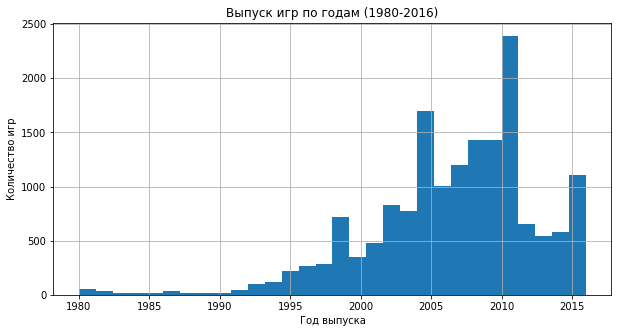

In [19]:
data['year_of_release'].sort_values().hist(bins=30, figsize=(10, 5));
plt.xlabel('Год выпуска');
plt.ylabel('Количество игр');
plt.title('Выпуск игр по годам (1980-2016)');

До 1995 года игровая индустрия была достаточно бедной. Зато с 1995 мы наблядаем явный рост количества выпускаемых игр. Отсеем ненужные данные и создадим более наглядный график.

In [20]:
data = data.loc[data['year_of_release'] > 1995]   
data.reset_index(drop= True , inplace= True )

year_of_release
2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     501
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
Name: name, dtype: int64

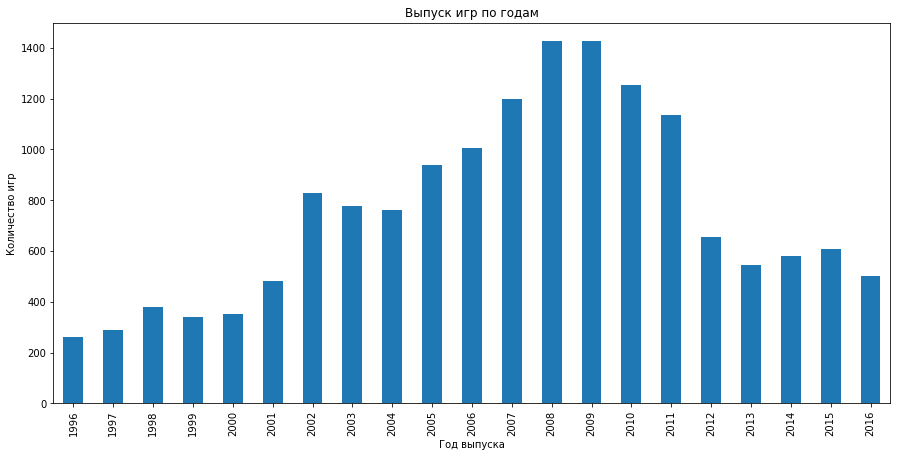

In [21]:
data.groupby("year_of_release")["name"].count().plot(kind='bar', figsize=(15,7), title='Выпуск игр по годам');
plt.xlabel('Год выпуска');
plt.ylabel('Количество игр');
display(data.groupby("year_of_release")["name"].count().sort_values(ascending=False));

**Вывод:** Больше всего игр выпускалось в 2007, 2008 и 2009 годах. В 1990-2000 годы количество выпускаемых игр не превышало 400 в год. 

### Cмотрим, как менялись продажи по платформам

#### Изучаем платформы по всему временному периоду

Для начала выберем платформы с наибольшими суммарными продажами.

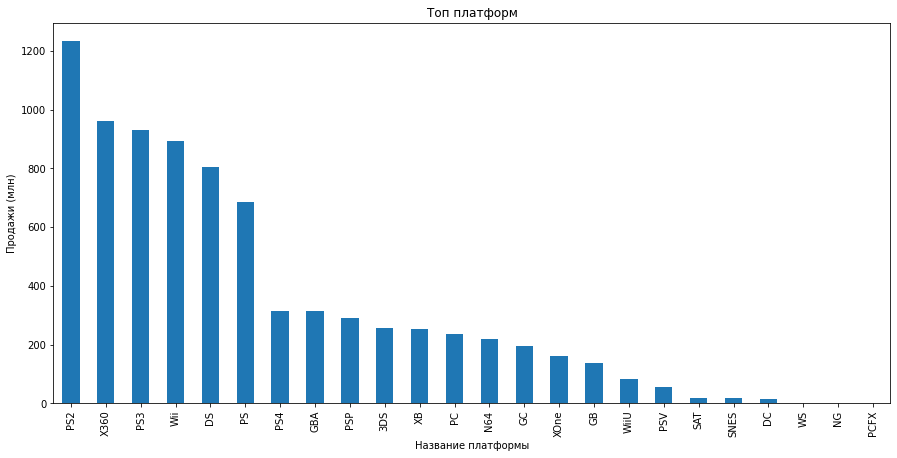

In [22]:
data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(15,7), title='Топ платформ');
plt.xlabel('Название платформы');
plt.ylabel('Продажи (млн)');

Как можно заметить, у некоторых платформ суммарная сумма продаж не превысила и 200 млн. Вряд ли эти платформы можно считать успешными, как соответственно и игры для них.  

Сначала визуализируем ситуацию на рынке игр по платформам по годам, не отсеивая безуспешные платформы.

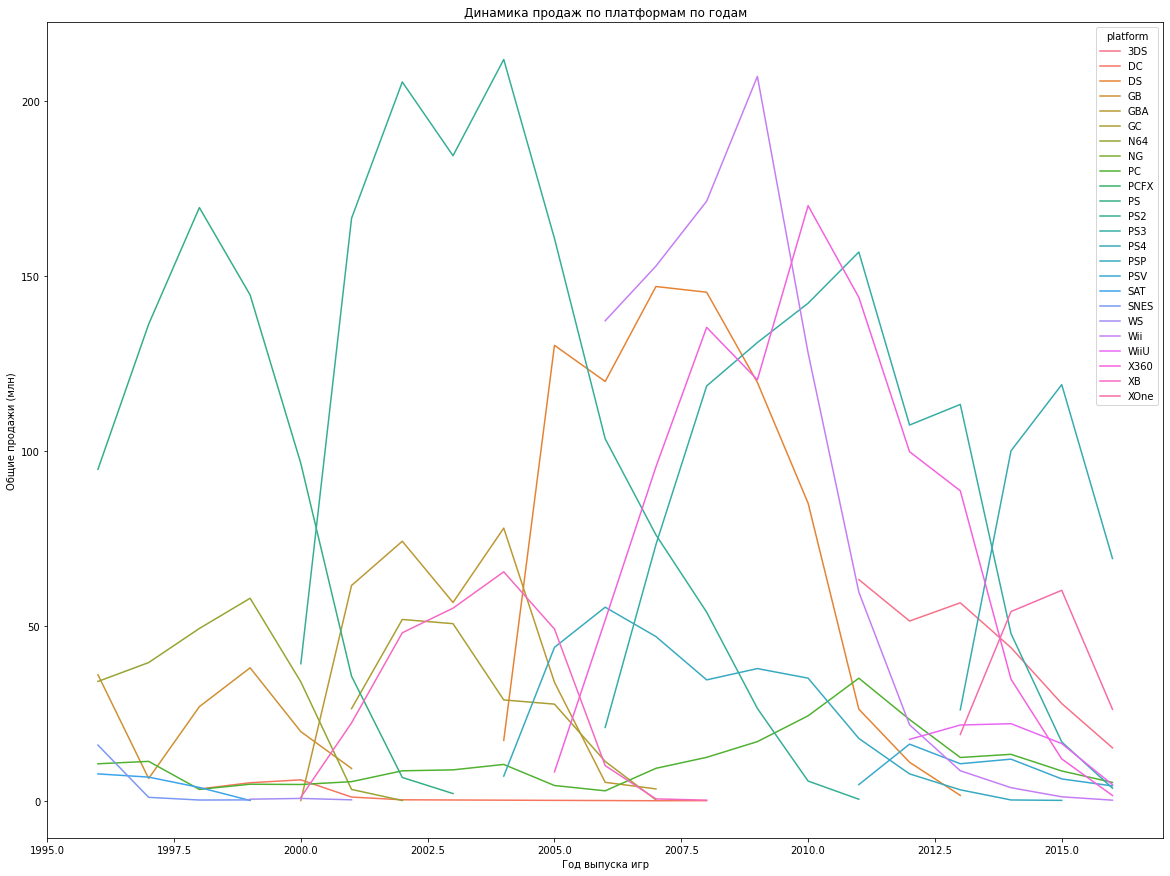

In [23]:
platforms_by_years = data.groupby(['platform','year_of_release'], as_index=False).agg({'total_sales':'sum'}).reset_index()
plt.figure(figsize=(20,15))
sns.lineplot(data=platforms_by_years, x="year_of_release", y="total_sales", hue='platform');
plt.xlabel('Год выпуска игр');
plt.ylabel('Общие продажи (млн)');
plt.title('Динамика продаж по платформам по годам');

#### Узнаем средний "срок жизни" платформ на рынке

Посмотрим сколько времени(в годах) платформы были активны на рынке. 

In [24]:
platform_life = data.groupby('platform')['year_of_release'].max() - data.groupby('platform')['year_of_release'].min()
platform_life

platform
3DS      5
DC      10
DS       9
GB       5
GBA      7
GC       6
N64      6
NG       0
PC      20
PCFX     0
PS       7
PS2     11
PS3     10
PS4      3
PSP     11
PSV      5
SAT      3
SNES     3
WS       2
Wii     10
WiiU     4
X360    11
XB       8
XOne     3
Name: year_of_release, dtype: int64

Уберем из данного списка "живые" на момент исследования платформы.

In [25]:
platform_life = platform_life.drop(platform_life.index[[0, 7, 8, 9, 12, 13, 14, 18, 19, 21]]) 

Теперь, имея список только из платформ, которые отжили свое, можно посчитать средний "срок жизни" платформ. 

In [26]:
platform_life.mean()

6.214285714285714

**Промежуточный вывод**: Средний срок жизни платформ - примерно 5 лет.

#### Изучаем платформы, исключая "мертвые"

Избавимся от безуспешных платформ и посмотрим на график еще раз. 

In [27]:
Xboxone_rate = data.query('platform == "XOne"')
PC_rate = data.query('platform == "PC"')

In [28]:
data = data[data.platform != 'GC' ]
data = data[data.platform != 'XOne' ]
data = data[data.platform != 'WiiU' ]
data = data[data.platform != 'PSV' ]
data = data[data.platform != 'SAT' ]
data = data[data.platform != 'SNES' ]
data = data[data.platform != 'DC' ]
data = data[data.platform != '2600' ]
data = data[data.platform != 'WS' ]
data = data[data.platform != 'NG' ]
data = data[data.platform != 'PCFX' ]

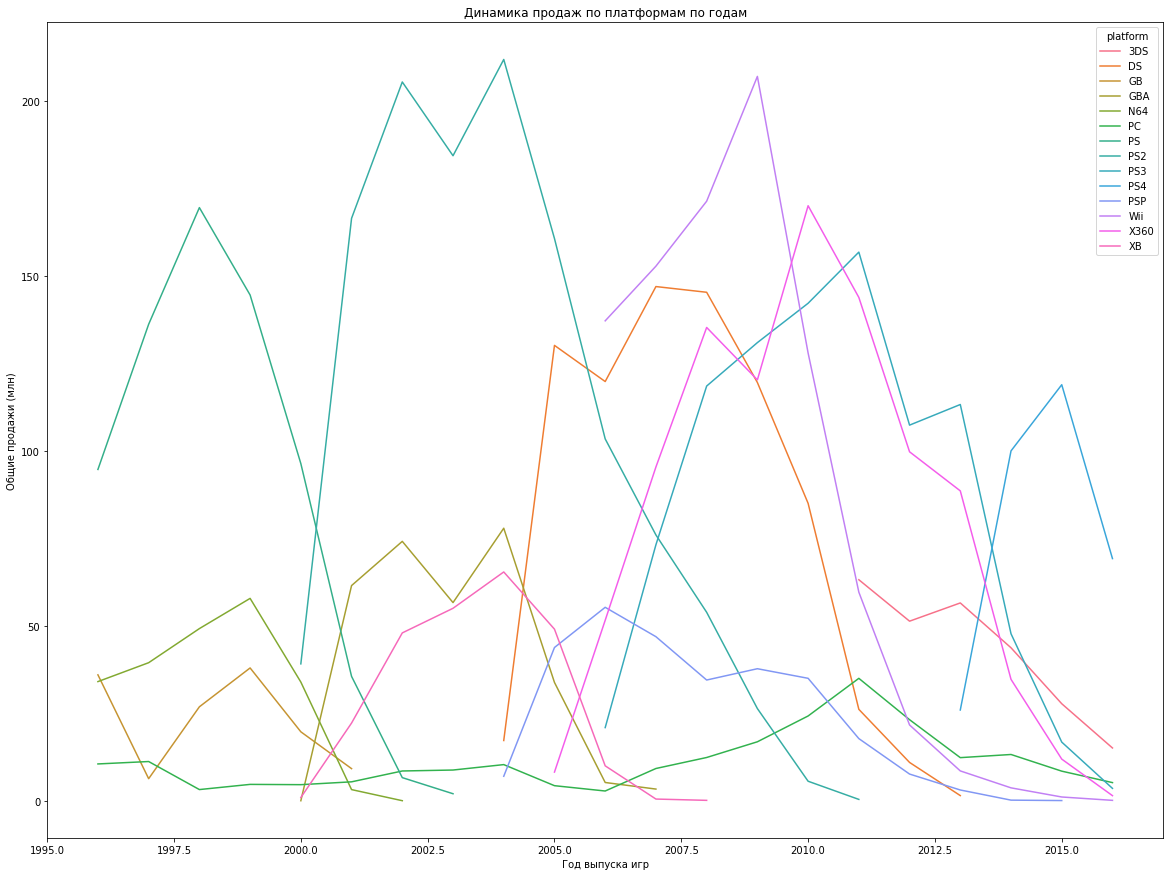

In [29]:
platforms_by_years = data.groupby(['platform','year_of_release'], as_index=False).agg({'total_sales':'sum'}).reset_index()
plt.figure(figsize=(20,15))
sns.lineplot(data=platforms_by_years, x="year_of_release", y="total_sales", hue='platform');
plt.xlabel('Год выпуска игр');
plt.ylabel('Общие продажи (млн)');
plt.title('Динамика продаж по платформам по годам');

**Вывод:** Можно заметить, что в 2004-2006 году появилось сразу несколько новых и успешных платформ, которые пользовались спросом минимум 5 лет. В основном, новые (стабильные и успешные) платформы появлялись, примерно раз в 5 лет. Это чуть меньше среднего срока "жизни" для платформы - примерно 6 лет.

### Изучим данные за соответствующий актуальный период

За актуальный период можно взять последние 2 года + данные 2016 года (пусть и неполные, зато самые актуальные). 

In [30]:
actual_data = data.query('year_of_release >= 2014').reset_index() 
actual_data

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,25,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
1,36,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,41,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
3,67,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,77,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,15697,Tsukigime Ranko's Longest Day,PS3,2014,Action,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
1088,15700,Aikatsu Stars! My Special Appeal,3DS,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
1089,15714,Dynasty Warriors: Eiketsuden,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
1090,15715,Metal Gear Solid V: Ground Zeroes,PC,2014,Action,0.00,0.01,0.00,0.00,80.0,7.6,M,0.01


#### Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.

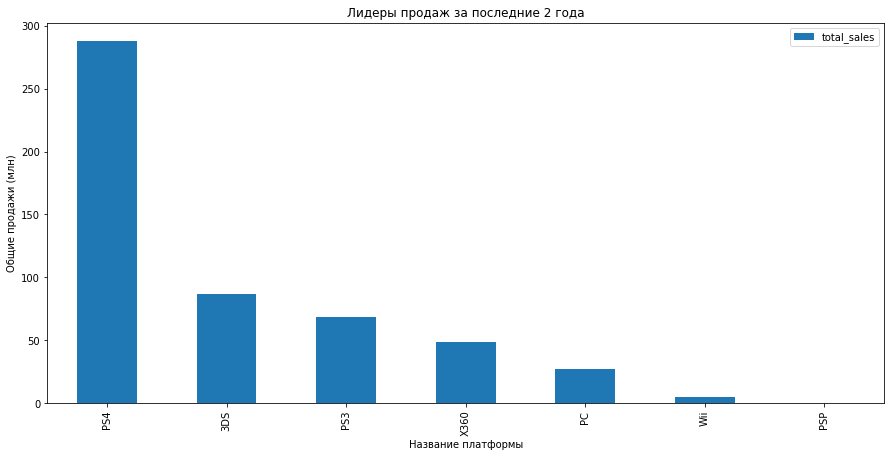

In [31]:
platforms_sales = actual_data.groupby('platform').agg({'total_sales':'sum'}).sort_values(by='total_sales', ascending=False)
platforms_sales.plot(kind='bar', figsize=(15,7), title='Лидеры продаж за последние 2 года'); 
plt.xlabel('Название платформы');
plt.ylabel('Общие продажи (млн)');

Судя по графику, Wii и PSP за последние 2 года спросом уже почти не пользовались. Лидерами продаж за последние 2 года являются: PS4, 3DS, PS3, X360 и PC соответственно.

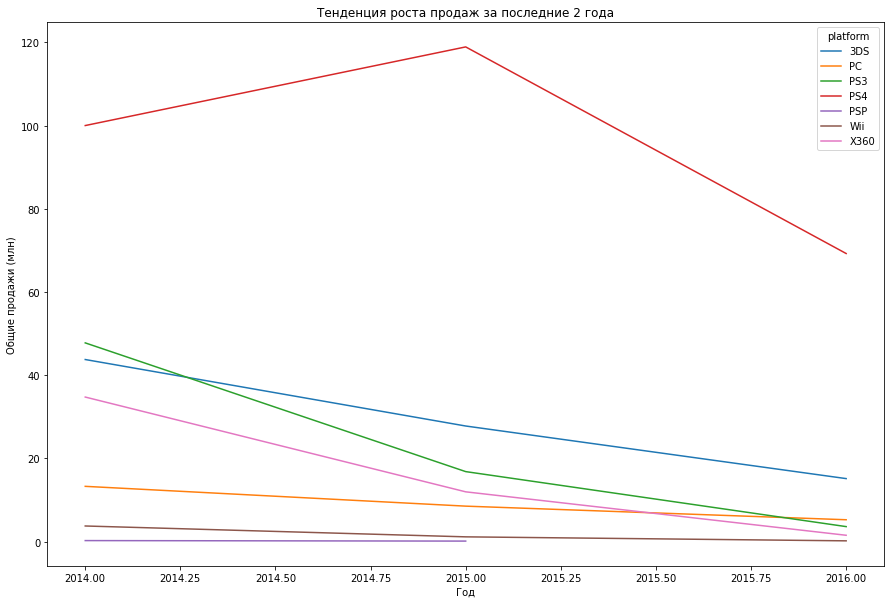

In [32]:
platforms_sales_lineplot = actual_data.groupby(['platform', 'year_of_release'], as_index=False).agg({'total_sales':'sum'}).reset_index()
plt.figure(figsize=(15,10))
plt.title('Тенденция роста продаж за последние 2 года')
sns.lineplot(data=platforms_sales_lineplot, x="year_of_release", y="total_sales", hue='platform', );
plt.xlabel('Год');
plt.ylabel('Общие продажи (млн)');

**Вывод:** Заметен явный рост продаж игр для платформы PS4 до 2015 года. Далее продажи начали достаточно резко падать 

Платформы PS3, X360 и 3DS потеряли в продажах за последние 2 года, но еще остаются на плаву. PC-гейминг довольно стабилен, продажи по этой платформе не сильно теряют объемы с годами.  

Платформы Wii и PSP изжили свое, в качестве потенциально прибыльных их рассматривать не рекомендуется.

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

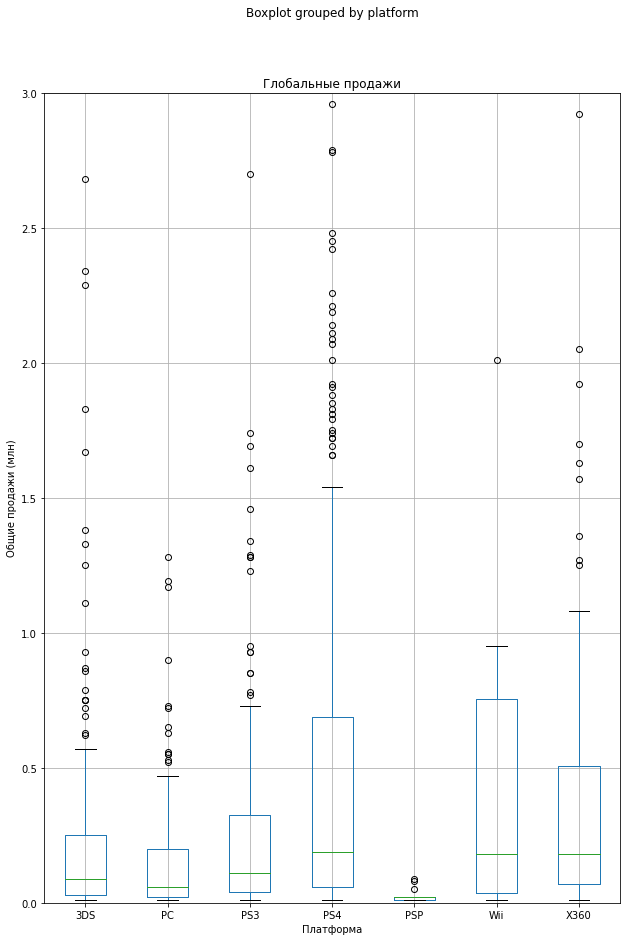

In [33]:
actual_data.boxplot(by='platform', column = ['total_sales'], grid=True, figsize=(10,15));
plt.ylim(0, 3);
plt.title('Глобальные продажи');
plt.xlabel('Платформа');
plt.ylabel('Общие продажи (млн)');

**Вывод**: судя по данным диаграммы размаха, можно подметить, что продажи игр для Wii, X360 и PS4 приносят больше всего прибыли. Их медиана продаж находится примерно на уровне 300тыс, а верхняя граница размаха для данных платформ около 900тыс, 1.1млн и 1.55млн соответственно. Далее идут 3DS, PS3 и PC. Платформа PSP - аутсайдер.

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков

Сначала посмотрим на зависимость продаж от оценок критиков на примере платформы `PS4`.

Корреляция оценок критиков и продаж PS4: 0.4023708563827227


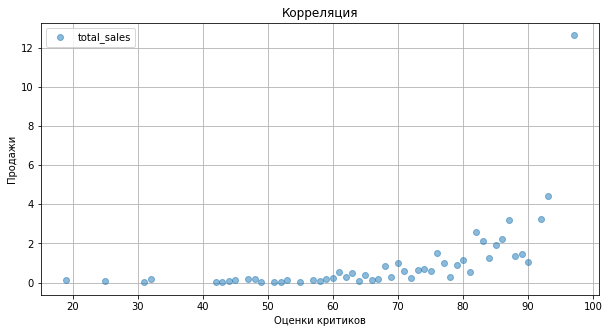

In [34]:
PS4 = actual_data.query('platform == "PS4"')
PS4.pivot_table(index='critic_score', values = 'total_sales').plot(grid=True, style='o', figsize=(10,5), alpha=0.5)
plt.title('Корреляция')
plt.xlabel('Оценки критиков')
plt.ylabel('Продажи')
print('Корреляция оценок критиков и продаж PS4:', PS4['total_sales'].corr(PS4['critic_score']))

Теперь исследуем по оценкам пользователей.

Корреляция оценок пользователей и продаж PS4: -0.03395270501315258


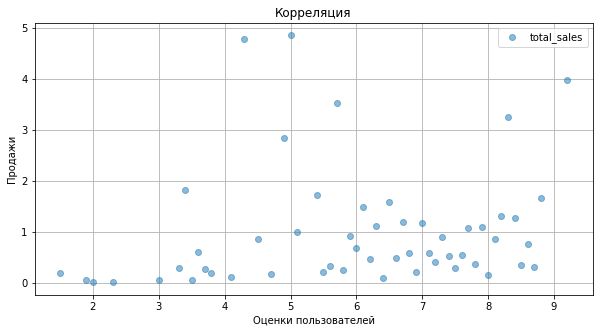

In [35]:
PS4.pivot_table(index='user_score', values = 'total_sales').plot(grid=True, style='o', figsize=(10,5), alpha=0.5)
plt.title('Корреляция')
plt.xlabel('Оценки пользователей')
plt.ylabel('Продажи')
print('Корреляция оценок пользователей и продаж PS4:',PS4['total_sales'].corr(PS4['user_score']))

**Вывод**: Оценки пользователей, как выяснилось, никак не влияют на продажи для популярной платформы. Оценки критиков же оказывают некоторое влияние на продажи. **Оценки критиков выше 75 баллов вызывают рост продаж игры.**

#### Соотнесем выводы с продажами игр на других платформах.

Для соотношения возьмем две наиболее успешные в последние 2 года платформы и две средней успешности.

Будем строить диаграмму рассеяния только для оценок критиков чтобы оценить влияние более высоких оценок на продажи.

Корреляция оценок критиков и продаж 3DS: 0.31411749286905105
Корреляция оценок пользователей и продаж 3DS: 0.23422305769017174


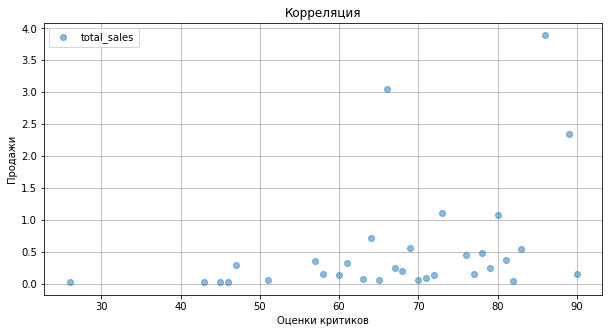

In [36]:
ThreeDS = actual_data.query('platform == "3DS"')
print('Корреляция оценок критиков и продаж 3DS:', ThreeDS['total_sales'].corr(ThreeDS['critic_score']))
print('Корреляция оценок пользователей и продаж 3DS:',ThreeDS['total_sales'].corr(ThreeDS['user_score']))

ThreeDS.pivot_table(index='critic_score', values = 'total_sales').plot(grid=True, style='o', figsize=(10,5), alpha=0.5);
plt.title('Корреляция');
plt.xlabel('Оценки критиков');
plt.ylabel('Продажи');

In [37]:
PS3 = actual_data.query('platform == "PS3"')
print('Корреляция оценок критиков и продаж PS3:', PS3['total_sales'].corr(PS3['critic_score']))
print('Корреляция оценок пользователей и продаж PS3:',PS3['total_sales'].corr(PS3['user_score']))

Корреляция оценок критиков и продаж PS3: 0.44657460493190704
Корреляция оценок пользователей и продаж PS3: -0.18411568267677292


**Промежуточный вывод:** Исследование подтвердилось.

Корреляция оценок критиков и продаж PC: 0.17463413769350036
Корреляция оценок пользователей и продаж PC: -0.07628975922388147


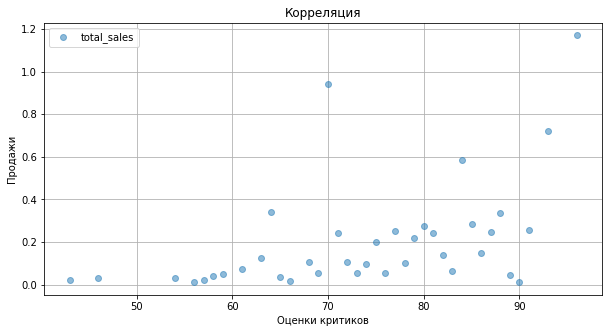

In [38]:
PC = actual_data.query('platform == "PC"')
print('Корреляция оценок критиков и продаж PC:', PC['total_sales'].corr(PC['critic_score']))
print('Корреляция оценок пользователей и продаж PC:',PC['total_sales'].corr(PC['user_score']))

PC.pivot_table(index='critic_score', values = 'total_sales').plot(grid=True, style='o', figsize=(10,5), alpha=0.5);
plt.title('Корреляция');
plt.xlabel('Оценки критиков');
plt.ylabel('Продажи');

In [39]:
X360 = actual_data.query('platform == "X360"')
print('Корреляция оценок критиков и продаж X360:', X360['total_sales'].corr(X360['critic_score']))
print('Корреляция оценок пользователей и продаж X360:',X360['total_sales'].corr(X360['user_score']))

Корреляция оценок критиков и продаж X360: 0.5257228356581523
Корреляция оценок пользователей и продаж X360: -0.14052931639059543


**Вывод:** Исследование полностью подтвердилось. Оценки пользователей никак не влияют на продажи игр на разных платформах. Оценки критиков же оказывают некоторое влияние на продажи **(чем выше оценка - тем сильнее влияние)**.

### Посмотрим на общее распределение продаж игр по жанрам.

genre
Action          150.84
Shooter         110.08
Sports           83.78
Role-Playing     83.27
Misc             22.79
Fighting         19.48
Racing           13.44
Simulation       12.75
Adventure        12.40
Platform         10.41
Strategy          3.53
Puzzle            0.93
Name: total_sales, dtype: float64

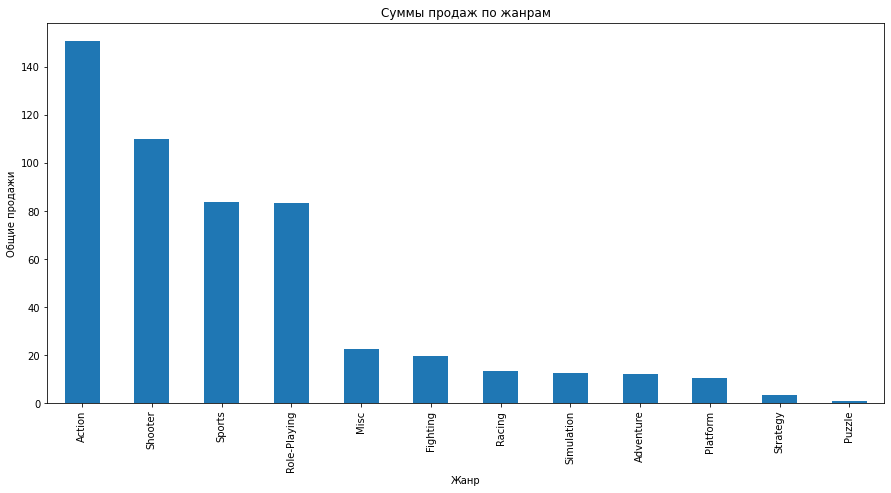

In [40]:
actual_data.groupby('genre')['total_sales'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(15,7), title='Суммы продаж по жанрам');
plt.xlabel('Жанр');
plt.ylabel('Общие продажи');
display(actual_data.groupby("genre")["total_sales"].sum().sort_values(ascending=False));

**Вывод**: По данному графику можно смело выделить жанр `Action`. Он несомненно является лидером по продажам. 

Далее, с небольшим расставанием друг от друга, идут `Shooter`, `Sports` и `Role-Playing` соответственно.

Делят 5-ое место в этом топ-5 прибыльных жанров - жанры `Misc` и `Fighting`.

Все остальные жанры имеют общие продажи менее 14млн за последние 2 года, что в сравнении с топ-5 жанрами(83.27 - 150.84 млн) значительно меньше. **Рекомендуется обратить внимание в 2017 году на жанры: `Action`, `Shooter`, `Role-Playing` и `Sports` .**

#### Рассмотрим успешность продаж

Как известно, `Action` - очень популярный среди разработчиков жанр. Но, как мы знаем, иногда игры просто "стряпают", оставляя пользователей недовольными приобретением. 

Рассмотрим успешность продаж. 

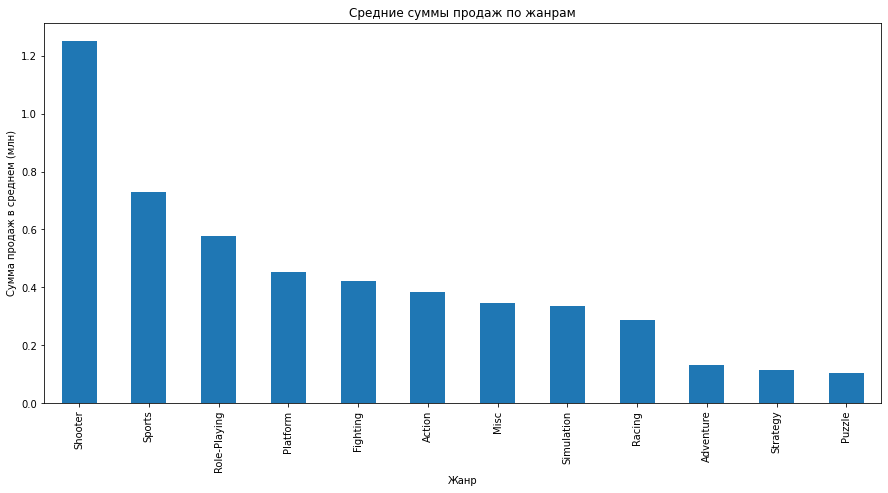

In [41]:
actual_data.groupby("genre")["total_sales"].mean().sort_values(ascending=False).plot(kind='bar', figsize=(15,7), title='Средние суммы продаж по жанрам');
plt.xlabel('Жанр');
plt.ylabel('Сумма продаж в среднем (млн)');

**Вывод:** успешнее всего выглядят жанры `Shooter`(при том с хорошей разницей), `Sports`, `Role-Playing`, `Platform` и `Fighting`. Самыми безуспешными являются жанры: `Adventure`, `Strategy` и `Puzzle`. 

`Sports`, `Role-Playing` и `Shooter` как по количеству тайтлов, так и по их качеству на высшем уровне. Игры жанра `Action`, не смотря на огромную продаваемость, успешны с переменным успехом 50/50. 

## Шаг 4. Составим портрет пользователя каждого региона

### Определим для пользователя каждого региона (NA, EU, JP):

#### Самые популярные платформы (топ-5)

Доли продаж для топ-5 популярных платформ региона NA:
PS4:54.5%
X360:15.6%
3DS:12.5%
PS3:12.2%
PC:4.0%


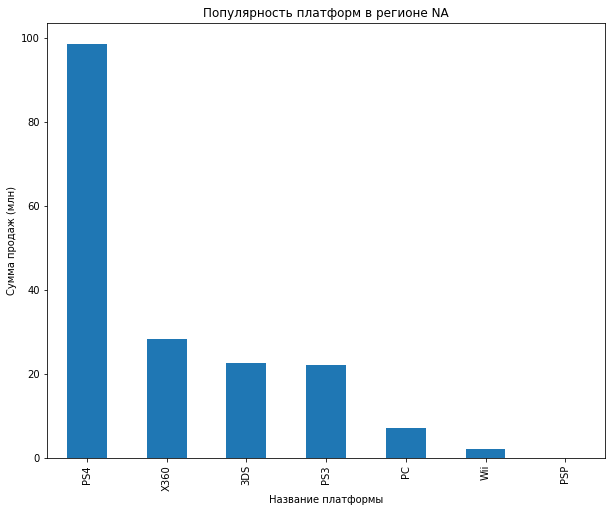

In [42]:
actual_data.groupby("platform")["na_sales"].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,8), title='Популярность платформ в регионе NA');
#actual_data.groupby("platform")["na_sales"].sum().sort_values(ascending=False).head()
plt.xlabel('Название платформы');
plt.ylabel('Сумма продаж (млн)');
print('Доли продаж для топ-5 популярных платформ региона NA:')
print('PS4:{:.1%}'.format( 98.61 / 180.91))
print('X360:{:.1%}'.format( 28.30 / 180.91))
print('3DS:{:.1%}'.format( 22.64 / 180.91))
print('PS3:{:.1%}'.format( 22.05 / 180.91))
print('PC:{:.1%}'.format( 7.23 / 180.91))

Доли продаж для топ-5 популярных платформ региона EU:
PS4:62.6%
PS3:12.3%
PC:8.6%
3DS:7.8%
X360:7.5%


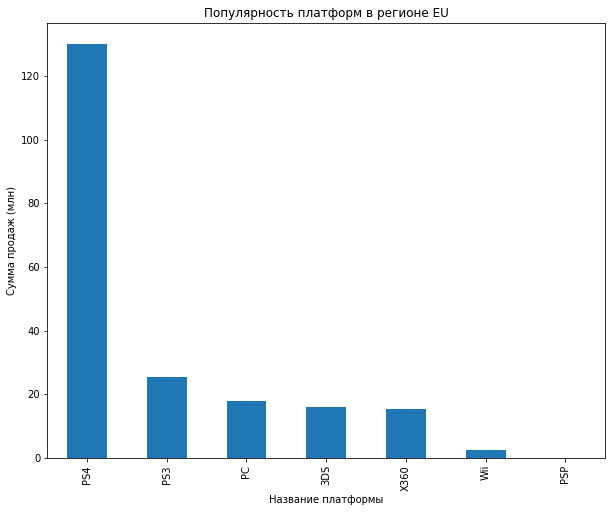

In [43]:
actual_data.groupby("platform")["eu_sales"].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,8), title='Популярность платформ в регионе EU');
#actual_data.groupby("platform")["eu_sales"].sum().sort_values(ascending=False).head()
plt.xlabel('Название платформы');
plt.ylabel('Сумма продаж (млн)');
print('Доли продаж для топ-5 популярных платформ региона EU:')
print('PS4:{:.1%}'.format( 130.04 / 207.75))
print('PS3:{:.1%}'.format( 25.54 / 207.75))
print('PC:{:.1%}'.format( 17.97 / 207.75))
print('3DS:{:.1%}'.format( 16.12 / 207.75))
print('X360:{:.1%}'.format( 15.49 / 207.75))

Доли продаж для топ-5 популярных платформ региона JP:
3DS:62.4%
PS4:21.2%
PS3:15.8%
PSP:0.5%
X360:0.1%


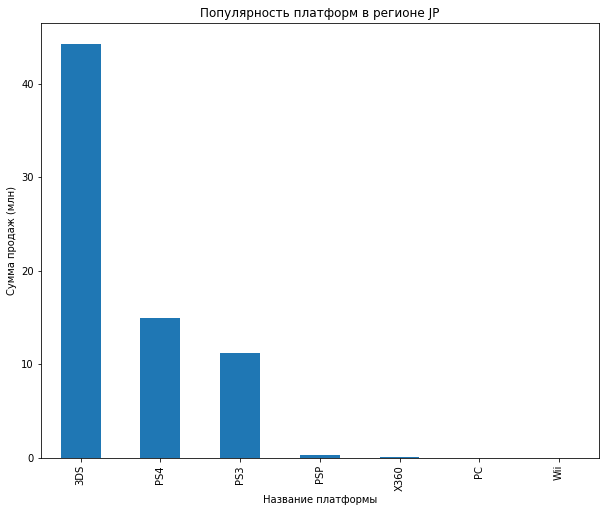

In [44]:
actual_data.groupby("platform")["jp_sales"].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,8), title='Популярность платформ в регионе JP');
#actual_data.groupby("platform")["jp_sales"].sum().sort_values(ascending=False).head() 
plt.xlabel('Название платформы');
plt.ylabel('Сумма продаж (млн)');
print('Доли продаж для топ-5 популярных платформ региона JP:')
print('3DS:{:.1%}'.format( 44.24 / 70.91))
print('PS4:{:.1%}'.format( 15.01 / 70.91))
print('PS3:{:.1%}'.format( 11.22 / 70.91))
print('PSP:{:.1%}'.format( 0.36 / 70.91))
print('X360:{:.1%}'.format( 0.08 / 70.91))

**Вывод:** в регионах `NA` и `EU` абсолютный лидер по продажам среди платформ - PS4. У региона `JP` другая ситуация, там лидером продаж является платформа 3DS.

#### Самые популярные жанры (топ-5)

Доли продаж для топ-5 популярных жанров региона NA:
Action:27.4%
Shooter:23.9%
Sports:17.7%
Role-Playing:14.4%
Misc:4.6%


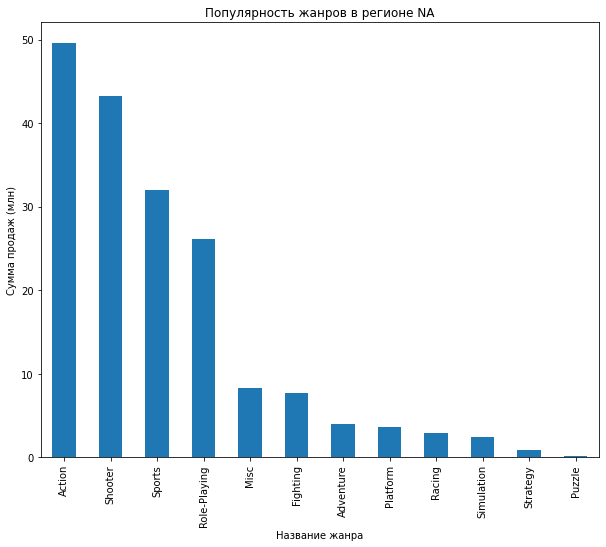

In [45]:
actual_data.groupby("genre")["na_sales"].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,8), title='Популярность жанров в регионе NA');
#actual_data.groupby("genre")["na_sales"].sum().sort_values(ascending=False).head()
plt.xlabel('Название жанра');
plt.ylabel('Сумма продаж (млн)');
print('Доли продаж для топ-5 популярных жанров региона NA:')
print('Action:{:.1%}'.format( 49.57 / 180.91))
print('Shooter:{:.1%}'.format( 43.24 / 180.91))
print('Sports:{:.1%}'.format( 32.01 / 180.91))
print('Role-Playing:{:.1%}'.format( 26.07 / 180.91))
print('Misc:{:.1%}'.format( 8.35 / 180.91))

Доли продаж для топ-5 популярных жанров региона EU:
Action:28.3%
Shooter:22.9%
Sports:17.9%
Role-Playing:11.4%
Misc:4.2%


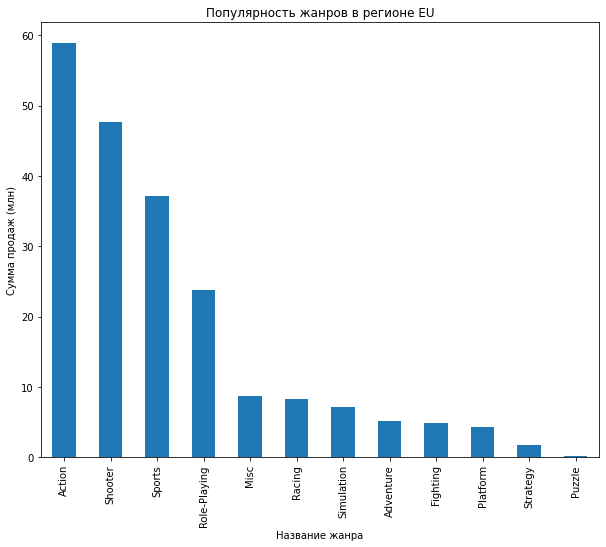

In [46]:
actual_data.groupby("genre")["eu_sales"].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,8), title='Популярность жанров в регионе EU');
#actual_data.groupby("genre")["eu_sales"].sum().sort_values(ascending=False).head()
plt.xlabel('Название жанра');
plt.ylabel('Сумма продаж (млн)');
print('Доли продаж для топ-5 популярных жанров региона EU:')
print('Action:{:.1%}'.format( 58.88 / 207.75))
print('Shooter:{:.1%}'.format( 47.63 / 207.75))
print('Sports:{:.1%}'.format( 37.14 / 207.75))
print('Role-Playing:{:.1%}'.format( 23.77 / 207.75))
print('Misc:{:.1%}'.format(8.78 / 207.75))

Доли продаж для топ-5 популярных жанров региона JP:
Role-Playing:36.9%
Action:33.8%
Fighting:6.9%
Shooter:4.5%
Misc:4.1%


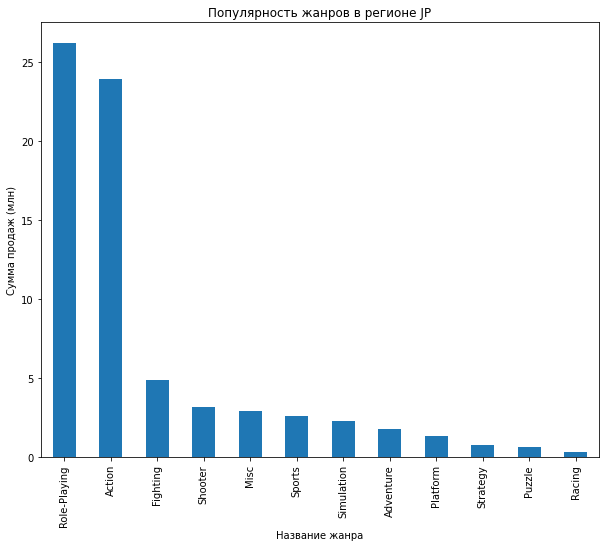

In [47]:
actual_data.groupby("genre")["jp_sales"].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,8), title='Популярность жанров в регионе JP');
#actual_data.groupby("genre")["jp_sales"].sum().sort_values(ascending=False).head() 
plt.xlabel('Название жанра');
plt.ylabel('Сумма продаж (млн)');
print('Доли продаж для топ-5 популярных жанров региона JP:')
print('Role-Playing:{:.1%}'.format( 26.20 / 70.91))
print('Action:{:.1%}'.format( 23.95 / 70.91))
print('Fighting:{:.1%}'.format( 4.92 / 70.91))
print('Shooter:{:.1%}'.format( 3.17 / 70.91))
print('Misc:{:.1%}'.format( 2.91 / 70.91))

**Вывод:** Во всех регионах большой популярностью пользуется жанр `Action`. 

Пользователи регионов `NA` и `EU` имеют примерно одинаковые вкусовые предпочтения в играх. Жанры `Action`, `Shooter`, `Sports`, `Role-Playing` и `Misc` занимают топ 5 в каждом регионе соответственно. Доли от общих продаж в этих регионах по данным играм тоже приблизительно одна.

По поводу продаж в регионе `JP`. Здесь ситуация складывается совсем иначе, доли продаж для топ-5 популярных жанров региона JP:

- Role-Playing:36.9%
- Action:33.8%
- Fighting:6.9%
- Shooter:4.5%
- Misc:4.1%

В данном регионе вкусовые предпочтения игроков складываются вокруг двух жанров - `Role-Playing` и `Action`. Игры двух этих жанров занимают почти 71% от общих продаж региона.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [48]:
#actual_data['rating'].unique()
def categorize_rating(row):
    try:
        if 'M' in row:
            return '1'
        elif 'E' in row:
            return '2'
        elif 'E10+' in row:
            return '3'
        elif 'T' in row:
            return '4'
        elif 'EC' in row:
            return '5'
        elif 'RP' in row:
            return '6'
    except:
        return '0'

In [49]:
actual_data['rating_category'] = actual_data['rating'].apply(categorize_rating)
actual_data['rating_category'] = actual_data['rating_category'].astype(int)

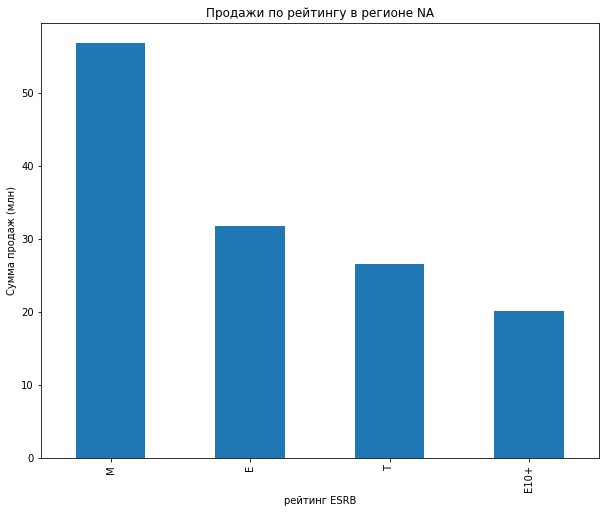

In [50]:
actual_data.groupby("rating")["na_sales"].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,8), title='Продажи по рейтингу в регионе NA');
plt.xlabel('рейтинг ESRB');
plt.ylabel('Сумма продаж (млн)');

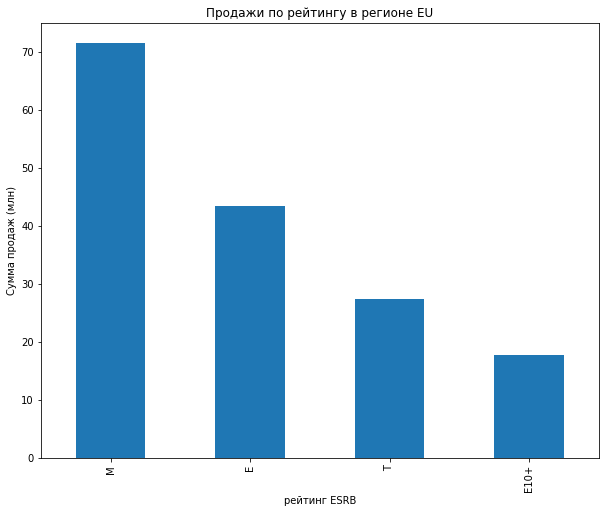

In [51]:
actual_data.groupby("rating")["eu_sales"].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,8), title='Продажи по рейтингу в регионе EU');
plt.xlabel('рейтинг ESRB');
plt.ylabel('Сумма продаж (млн)');

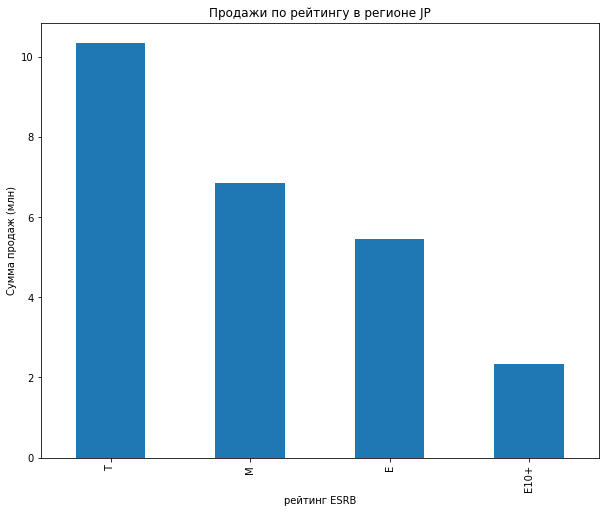

In [52]:
actual_data.groupby("rating")["jp_sales"].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,8), title='Продажи по рейтингу в регионе JP');
plt.xlabel('рейтинг ESRB');
plt.ylabel('Сумма продаж (млн)');

In [53]:
print('Корреляция рейтинга ESRB и продаж в NA:', actual_data['na_sales'].corr(actual_data['rating_category']))
print('Корреляция рейтинга ESRB и продаж в EU:', actual_data['eu_sales'].corr(actual_data['rating_category']))
print('Корреляция рейтинга ESRB и продаж в JP:', actual_data['jp_sales'].corr(actual_data['rating_category']))

Корреляция рейтинга ESRB и продаж в NA: 0.036649680968533625
Корреляция рейтинга ESRB и продаж в EU: 0.030306448088915278
Корреляция рейтинга ESRB и продаж в JP: -0.07906940920140335


**Вывод**: судя по результатам корреляции, продажи в регионах практически не зависят от рейтинга ESRB.

По графикам же, для регионов NA и EU преобладают продажи игр с рейтингом `M`, а в регионе JP - рейтингом `T`.

## Шаг 5. Проверим гипотезы

### Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Нулевая гипотеза:** Средние пользовательские рейтинги платформ Xbox One и PC равны. **Альтернативная гипотеза:** Средние пользовательские рейтинги платформы Xbox One ниже, чем рейтинги платформы PC. 

In [54]:
PC_rate = PC_rate.dropna()
Xboxone_rate = Xboxone_rate.dropna()

In [55]:
alpha=0.05

results = st.ttest_ind(Xboxone_rate['user_score'], PC_rate['user_score'], equal_var=False, alternative = 'less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.396594284025814e-06
Отвергаем нулевую гипотезу


**Вывод**: для проверки данной гипотезы была взята нулевая гипотеза, в соответствии с формулировкой самой гипотезы, а альтернативную гипотезу мы выдвинули в соответствии с опытом в области гейминга. Оценки пользователей PC обычно всегда выше, чем для платформы Xbox One. Соответственно, тест это подтвердил. Результат - **Отвергаем нулевую гипотезу. Средние пользовательские рейтинги платформы Xbox One ниже, чем рейтинги платформы PC.**    

### Гипотеза 2. Средние пользовательские рейтинги жанров Action  и Sports  разные.

**Нулевая гипотеза**: Средние пользовательские рейтинги жанров Action и Sports равны. **Альтернативная гипотеза**: Средние пользовательские рейтинги жанров Action и Sports не равны.

In [56]:
Action_rate = actual_data.query('genre == "Action"')
Sports_rate = actual_data.query('genre == "Sports"')
Action_rate = Action_rate.dropna()
Sports_rate = Sports_rate.dropna()

In [57]:
alpha=1

results = st.ttest_ind(Action_rate['user_score'], Sports_rate['user_score'], equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.0003442993924067165
Отвергаем нулевую гипотезу


**Вывод:** дл проверки данной гипотезы была взята нулевая гипотеза "Средние пользовательские рейтинги жанров Action и Sports равны", так как правила при проверке гипотез статистическими тестами: нулевая содержит равенство, альтернативная - либо неравенство, либо больше-меньше (при односторонней). Такие варианты перекрывают возможные исходы. Соответственно результат - **Отвергаем нулевую гипотезу. Средние пользовательские рейтинги жанров Action и Sports разные.**

## Общий вывод

1. В результате проведенного нами исследования можно подытожить:
- Больше всего игр выпускалось в 2007, 2008 и 2009 годах. В 1990-2000 годы количество выпускаемых игр не превышало 400 в год.
- В основном, новые (стабильные и успешные) платформы появляляются примерно раз в 5 лет.
- Средний срок "жизни" платформы - приблизительно 5 лет.

2. **Заметен явный рост продаж игр для платформы PS4 до 2015 года. Далее продажи начали достаточно резко падать** Платформы Платформы PS3, X360 и 3DS потеряли в продажах за последние 2 года, но вполне остаются на плаву. PC-гейминг довольно стабилен, продажи по этой платформе не сильно теряют объемы с годами. **(Год выхода на рынок PS4 - 2013. Несмотря на падение, данная платформа еще будет пользоваться активным спросом в 2017 году)**


3. **Платформы Wii и PSP изжили свое, в качестве потенциально прибыльных их рассматривать не рекомендуется.**


4. Оценки пользователей никак не влияют на продажи игр на разных платформах. **Оценки критиков же оказывают некоторое влияние на продажи (чем выше оценка - тем сильнее влияние, рост наблюдается от отметки в 75 баллов**).


5. **Жанр `Action` несомненно является лидером по продажам**. ДДалее, с небольшим расставанием друг от друга, идут `Shooter`, `Sports` и `Role-Playing` соответственно. Делят 5-ое место в этом топ-5 прибыльных жанров - жанры `Misc` и `Fighting`. Все остальные жанры имеют общие продажи менее 14млн за последние 2 года, что в сравнении с топ-5 жанрами(83.27 - 150.84 млн) значительно меньше. **Рекомендуется обратить внимание в 2017 году на жанры: `Action`, `Shooter`, `Role-Playing` и `Sports` .**


6. **Успешнее всего выглядят жанры `Shooter`(при том с хорошей разницей), `Sports`, `Role-Playing`, `Platform` и `Fighting`**. Самыми безуспешными являются жанры: `Adventure`, `Strategy` и `Puzzle`. 
   
   **`Sports`, `Role-Playing` и `Shooter` как по количеству тайтлов, так и по их качеству на высшем уровне**. Игры жанра `Action`, не смотря на огромную продаваемость, успешны с переменным успехом 50/50.  


5. **В регионах `NA` и `EU` абсолютный лидер по продажам среди платформ - PS4. У региона `JP` другая ситуация, там лидером продаж является платформа 3DS.**


6. **Во всех регионах большой популярностью пользуется жанр `Action`.** Пользователи регионов `NA` и `EU` имеют примерно одинаковые вкусовые предпочтения в играх. Жанры `Action`, `Shooter`, `Sports`, `Role-Playing` и `Misc` занимают топ 5 в каждом регионе соответственно. Доли от общих продаж в этих регионах по данным играм тоже приблизительно одна.

   По поводу продаж в регионе `JP`. Здесь ситуация складывается совсем иначе, доли продаж для топ-5 популярных жанров региона JP:

- Role-Playing:36.9%
- Action:33.8%
- Fighting:6.9%
- Shooter:4.5%
- Misc:4.1%

    В данном регионе вкусовые предпочтения игроков складываются вокруг двух жанров - `Role-Playing` и `Action`. Игры двух этих жанров занимают почти 71% от общих продаж региона.